# Symbolic Regression mono-objective

#### 1. Libraries importation

In [1]:
import math
import random
import csv
import numpy
import operator
import matplotlib.pyplot as plt
from deap import algorithms, base, creator , tools, gp

#### 2. Defining primitive set

In [2]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

#Second argument = number of variables in problem (this case, 'x')
pset = gp.PrimitiveSet("MAIN", 1)
#Second argument = arity
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)


pset.addEphemeralConstant("rand101", lambda: random.randint(-10,10))
pset.renameArguments(ARG0='x')

#### 3. Parameters definition

In [3]:
#Defining fitness class
creator.create("FitnessMin", base.Fitness, weights=(-1,))
#Defining individuals shape and associatinf fitness attribute
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#Creating toolbox to register: population creation, evaluation function, selection mecanism
#and genetic operators
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    #sqerrors = ((func(x) - x**4 - x**3 - x**2 - x )**2 for x in points)
    sqerrors = ((func(x) - (math.sin(x**2))**2 - math.sin(x) - (math.cos(x**2))**2 - math.cos(x) - x**3 - 2*x**2 - 4 )**2 for x in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[x for x in range(-100,100)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

#### 4. Algorithm initialization

In [4]:
def main():
    random.seed(318)

    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)

    stats_fit_mse = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(mse=stats_fit_mse, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    pop, log, hof = algorithms.eaSimpleOr(pop, toolbox, .8, .1, 10, stats=mstats,
                                   halloffame=hof, verbose=True)
    return pop, log, hof

if __name__ == "__main__":
    pop, log, hof = main()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.44it/s]

Entering 1th generation
Entering 2th generation
Entering 3th generation
Entering 4th generation
Entering 5th generation
Entering 6th generation
Entering 7th generation
Entering 8th generation
Entering 9th generation
Entering 10th generation


,mse_avg,mse_std,mse_min,mse_max,mse_gen,mse_nevals,size_avg,size_std,size_min,size_max,size_gen,size_nevals
0,1.427472e+11,9.618363e+07,1.424676e+11,1.427872e+11,1.0,9.0,4.8,2.181742,2.0,9.0,1.0,9.0
1,1.428073e+11,2.777664e+08,1.423078e+11,1.432675e+11,2.0,9.0,4.7,1.676305,3.0,8.0,2.0,9.0
2,1.426919e+11,1.006733e+08,1.425473e+11,1.428271e+11,3.0,9.0,4.9,2.118962,1.0,9.0,3.0,9.0
3,1.426924e+11,1.043083e+08,1.425474e+11,1.427930e+11,4.0,9.0,5.2,1.469694,3.0,8.0,4.0,9.0
4,1.425589e+11,1.490829e+08,1.423078e+11,1.427870e+11,5.0,8.0,6.1,1.135782,5.0,9.0,5.0,8.0
5,1.425249e+11,2.273919e+08,1.420685e+11,1.427926e+11,6.0,8.0,6.3,1.846619,3.0,9.0,6.0,8.0
6,1.424892e+11,2.126093e+08,1.420685e+11,1.427930e+11,7.0,10.0,5.7,1.345362,3.0,7.0,7.0,10.0
7,1.424077e+11,2.889635e+08,1.418691e+11,1.428329e+11,8.0,10.0,6.9,1.972308,5.0,11.0,8.0,10.0
8,1.421763e+11,3.685072e+08,1.415905e+11,1.427869e+11,9.0,8.0,8.8,2.441311,5.0,11.0,9.0,8.0
9,1.416862e+11,3.451418e+08,1.409149e+11,1.423078e+11,10.0,9.0,11.8,3.487119,5.0,19.0,10.0,9.0


Algorithm execution took 0.22624707221984863 s


### 5. Simplifying resultant equation

In [5]:
from sympy import sympify, sin, cos
def protectedDiv(left, right):
    try:
        return left / right
    except:
        return 1
locals = {
    'sub': lambda x, y : x - y,
    'protectedDiv': protectedDiv,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y
}
locals = {
    'sub': operator.sub,
    'protectedDiv': protectedDiv,
    'mul': operator.mul,
    'add': operator.add,
    'neg': operator.neg,
    'pow': lambda x, y : x**y
}
ind = hof.__getitem__(0).__str__()
print(f'original: {ind}')
expr = sympify(ind , locals=locals)
print(f'simplified: {expr}')


original: mul(x, add(add(6, add(add(6, 6), 6)), add(add(6, add(add(6, x), 6)), 6)))
simplified: x*(x + 48)


In [16]:
hof.__getitem__(0).compile(3)

AttributeError: 'Individual' object has no attribute 'compile'

In [7]:
hoho

<function <lambda>(x)>

### 6. Graphs

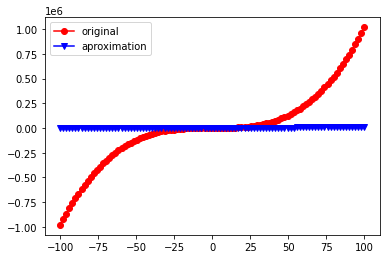

In [8]:
fig, ax = plt.subplots()
original = lambda x: (math.sin(x**2))**2 + math.sin(x) + (math.cos(x**2))**2 + math.cos(x) + x**3 + 2*x**2 + 4
ax.plot(numpy.linspace(-100,100,100), [original(x) for x in numpy.linspace(-100,100,100)], color = 'r', marker = 'o', label='original')
aprox = lambda x: toolbox.compile(hof.__getitem__(0))(x)
ax.plot(numpy.linspace(-100,100,100), [aprox(x) for x in numpy.linspace(-100,100,100)], color = 'b', marker='v', label='aproximation')
plt.legend()

In [9]:
hof.__getitem__(0)

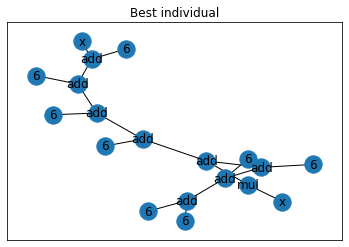

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
nodes, edges, labels = gp.graph(hof.__getitem__(0))

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos=nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)

plt.title(label = 'Best individual')
plt.show()

In [11]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)
str(tree)

'protectedDiv(x, x)'

In [12]:
expr

In [13]:
tree